**Data Overview**

This dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.


```



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Input
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import ResNet101, ResNet152, ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
disease_types = ['Covid', 'Non-Covid']

train_dir = data_dir = '/content/drive/MyDrive/Capstone Project/Dataset'
train_data = []

for index, sp in enumerate(disease_types):
  for file in os.listdir(os.path.join(train_dir, sp)):
    train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns = ['File', 'ID', 'Disease Type'])
train

,File,ID,Disease Type
0,Covid/Covid (215).png,0,Covid
1,Covid/Covid (124).png,0,Covid
2,Covid/Covid (26).png,0,Covid
3,Covid/Covid (187).png,0,Covid
4,Covid/Covid (203).png,0,Covid
...,...,...,...
2476,Non-Covid/Non-Covid (1132).png,1,Non-Covid
2477,Non-Covid/Non-Covid (1061).png,1,Non-Covid
2478,Non-Covid/Non-Covid (1174).png,1,Non-Covid
2479,Non-Covid/Non-Covid (1022).png,1,Non-Covid


,File,ID,Disease Type
0,Non-Covid/Non-Covid (392).png,1,Non-Covid
1,Covid/Covid (379).png,0,Covid
2,Non-Covid/Non-Covid (99).png,1,Non-Covid
3,Covid/Covid (171).png,0,Covid
4,Covid/Covid (635).png,0,Covid
...,...,...,...
2476,Covid/Covid (154).png,0,Covid
2477,Covid/Covid (478).png,0,Covid
2478,Non-Covid/Non-Covid (796).png,1,Non-Covid
2479,Non-Covid/Non-Covid (319).png,1,Non-Covid


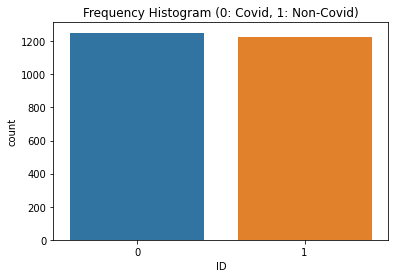

In [4]:
Seed = 45
train = train.sample(frac = 1, replace = False, random_state = Seed)

# Reset Index Numbers of dataset
train = train.reset_index(drop = True)

sns.countplot(x = 'ID', data = train).set_title("Frequency Histogram (0: Covid, 1: Non-Covid)")
train

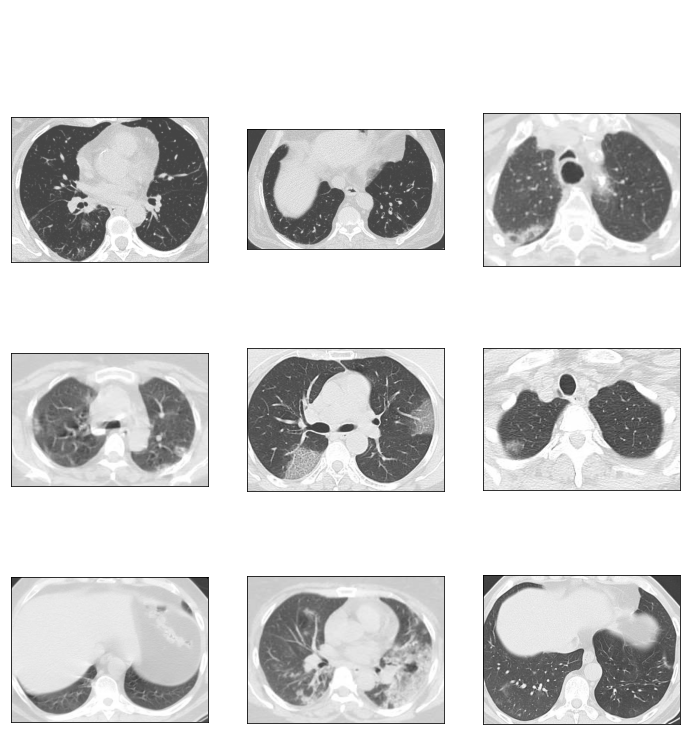

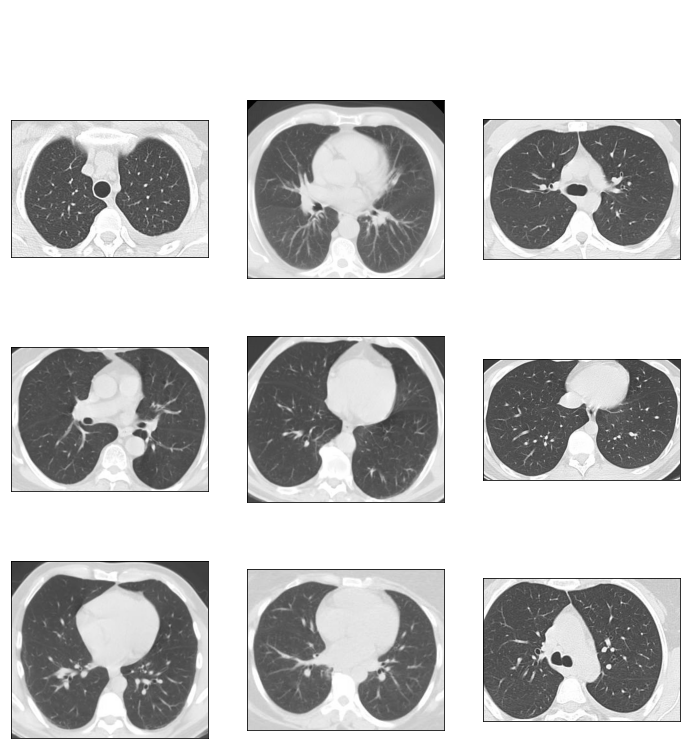

In [5]:
from collections.abc import ValuesView
def plot_defects(defect_types, rows, cols):
  fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
  defect_files = train['File'][train['Disease Type'] == defect_types].values
  n = 0
  fig.suptitle(defect_types, fontsize = 22, color = "white")
  for i in range(rows):
    for j in range(cols):
      image_path = os.path.join(data_dir, defect_files[n])
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      ax[i, j].imshow(cv2.imread(image_path))
      n = n+1

plot_defects('Covid', 3, 3)
plot_defects('Non-Covid', 3, 3)

In [6]:
IMAGE_SIZE = 224

# OpenCV function to load colored image
def read_image(filepath):
  return cv2.imread(os.path.join(data_dir, filepath))

#OpenCV Function to resize an image
def resize_image(image, image_size):
  return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

Train Shape: (2481, 224, 224, 3)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
# Dataframe split to trin and validation set(80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size = 0.2, random_state = Seed)

print(f'X_train : {X_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'Y_train : {Y_train.shape}')
print(f'Y_val : {Y_val.shape}')

X_train : (1984, 224, 224, 3)
X_val : (497, 224, 224, 3)
Y_train : (1984, 2)
Y_val : (497, 2)


In [11]:
# Architectural function for ResNet152
def build_resnet152(IMAGE_SIZE, channels):

    resNet152 = ResNet152(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = resNet152(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

234708992/234698864 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                            

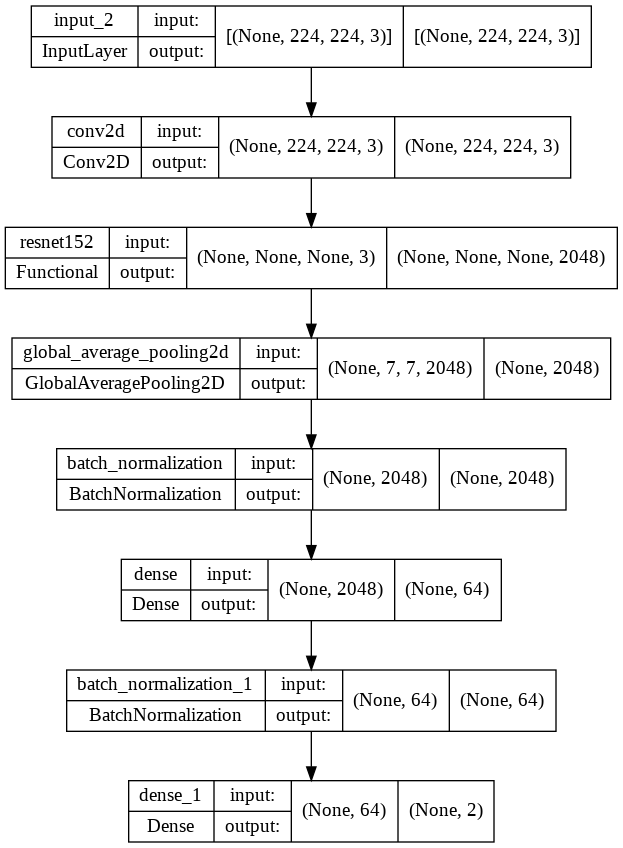

In [12]:
channels = 3

model = build_resnet152(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 2,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model.h5', verbose = 2, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [13]:
BATCH_SIZE = 8
EPOCHS = 50
callback = EarlyStopping(monitor='val_loss', patience=50)
# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [callback],
               validation_data = (X_val, Y_val))

Epoch 1/50
248/248 [==============================] - 105s 300ms/step - loss: 0.6459 - accuracy: 0.7329 - val_loss: 0.9823 - val_accuracy: 0.4970
Epoch 2/50
248/248 [==============================] - 71s 286ms/step - loss: 0.4125 - accuracy: 0.8226 - val_loss: 0.9430 - val_accuracy: 0.5111
Epoch 3/50
248/248 [==============================] - 71s 284ms/step - loss: 0.3938 - accuracy: 0.8362 - val_loss: 3.1285 - val_accuracy: 0.4970
Epoch 4/50
248/248 [==============================] - 72s 291ms/step - loss: 0.3662 - accuracy: 0.8443 - val_loss: 0.7566 - val_accuracy: 0.6841
Epoch 5/50
248/248 [==============================] - 71s 285ms/step - loss: 0.3457 - accuracy: 0.8569 - val_loss: 0.3887 - val_accuracy: 0.8270
Epoch 6/50
248/248 [==============================] - 71s 285ms/step - loss: 0.3331 - accuracy: 0.8654 - val_loss: 0.3839 - val_accuracy: 0.8249
Epoch 7/50
248/248 [==============================] - 71s 286ms/step - loss: 0.3366 - accuracy: 0.8669 - val_loss: 0.5737 - val_a

True Positive: 219
False Negative: 31
True Negative: 239
False Positive: 8
True Positive Rate: 0.876
True Negative Rate: 0.9676113360323887

16/16 [==============================] - 4s 225ms/step - loss: 0.2825 - accuracy: 0.9215

Final Loss: 0.28254783153533936, Final Accuracy: 0.9215291738510132


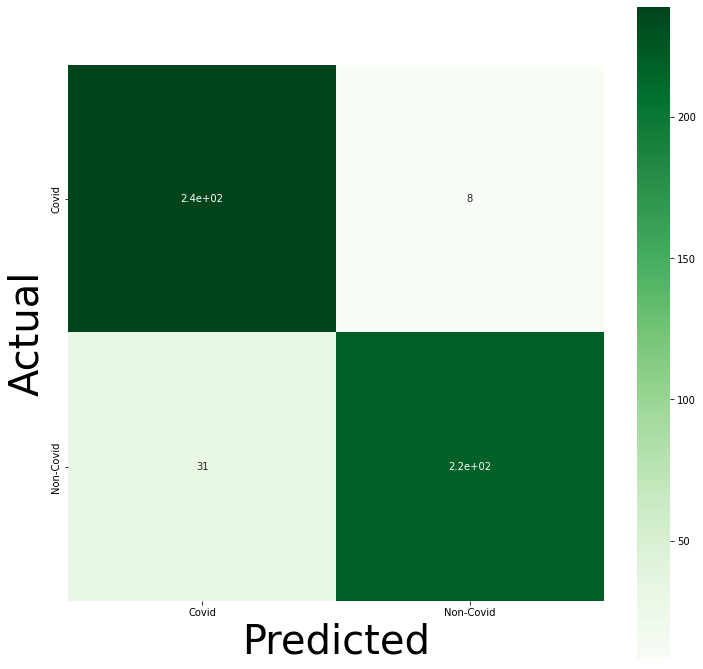

In [14]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

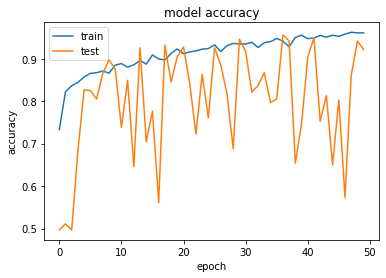

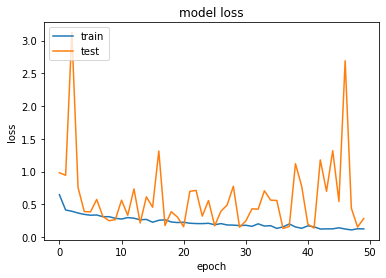

In [15]:
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

[0.00340763 0.99659234]


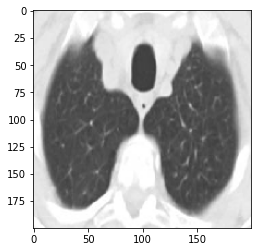

Prediction: Non Covid-19


In [16]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Capstone Project/Dataset/Non-Covid/Non-Covid (1).png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img('/content/drive/MyDrive/Capstone Project/Dataset/Non-Covid/Non-Covid (1).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])